In [28]:
import boto3
import ast
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import boxcox
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error
from IPython.display import clear_output
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import RFE, RFECV

from precision_recall_cutoff import precision_recall_cutoff

### Part (a)

In [30]:
## Defining the s3 bucket
s3 = boto3.resource('s3')
bucket_name = 'ryan-greiner-bucket'
bucket = s3.Bucket(bucket_name)

## Defining the file to be read from s3 bucket
file_key = 'predictive_analytics/Customers.csv'
bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

## Reading CSV file
customers = pd.read_csv(file_content_stream).drop(columns = 'CustomerID')
customers.head()

,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size
0,Male,19,15000,39,Healthcare,1,4
1,Male,21,35000,81,Engineer,3,3
2,Female,20,86000,6,Engineer,1,1
3,Female,23,59000,77,Lawyer,0,2
4,Female,31,38000,40,Entertainment,2,6


# EDA

## Exploratory Charts

##### Correlations among Numeric Features

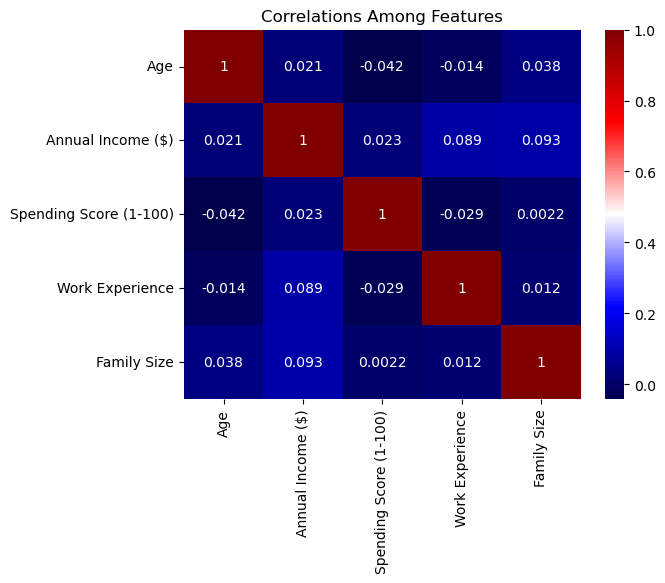

In [3]:
sns.heatmap(customers.drop(columns = ['Gender', 'Profession']).corr(), annot = True, cmap = 'seismic').set_title('Correlations Among Features');

The interactions in this data frame are not strong but the following are still worth considering:
- Annual Income - Work Experience
- Annual Income - Family Size

##### Box-Plots for Categorical Features

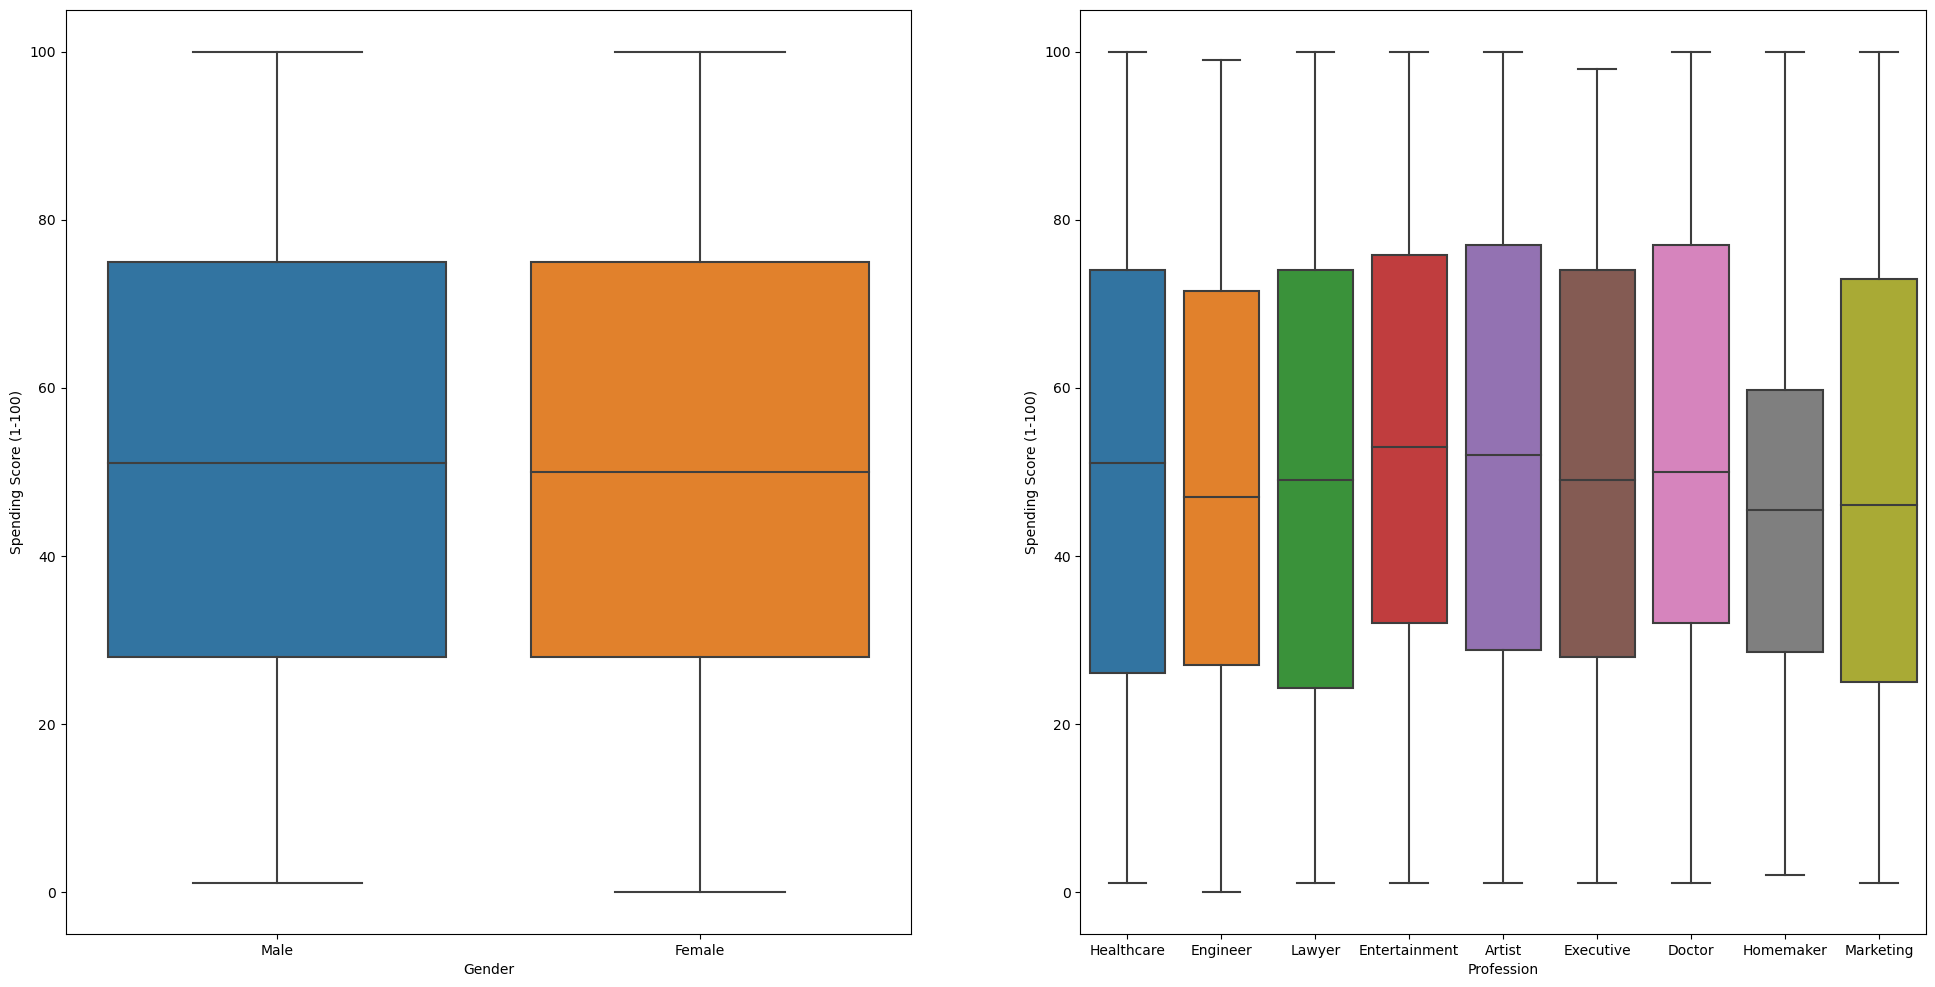

In [5]:
fig, axes = plt.subplots(1, 2, figsize = (24,12))

sns.boxplot(ax = axes[0], x = 'Gender', y = 'Spending Score (1-100)', data = customers);
sns.boxplot(ax = axes[1], x = 'Profession', y = 'Spending Score (1-100)', data = customers);

The charts above show a few interesting insights.
- Spending Score does not seem to be affected by Gender
- Spending Score is affected by Profession

##### Histograms of Numeric Features

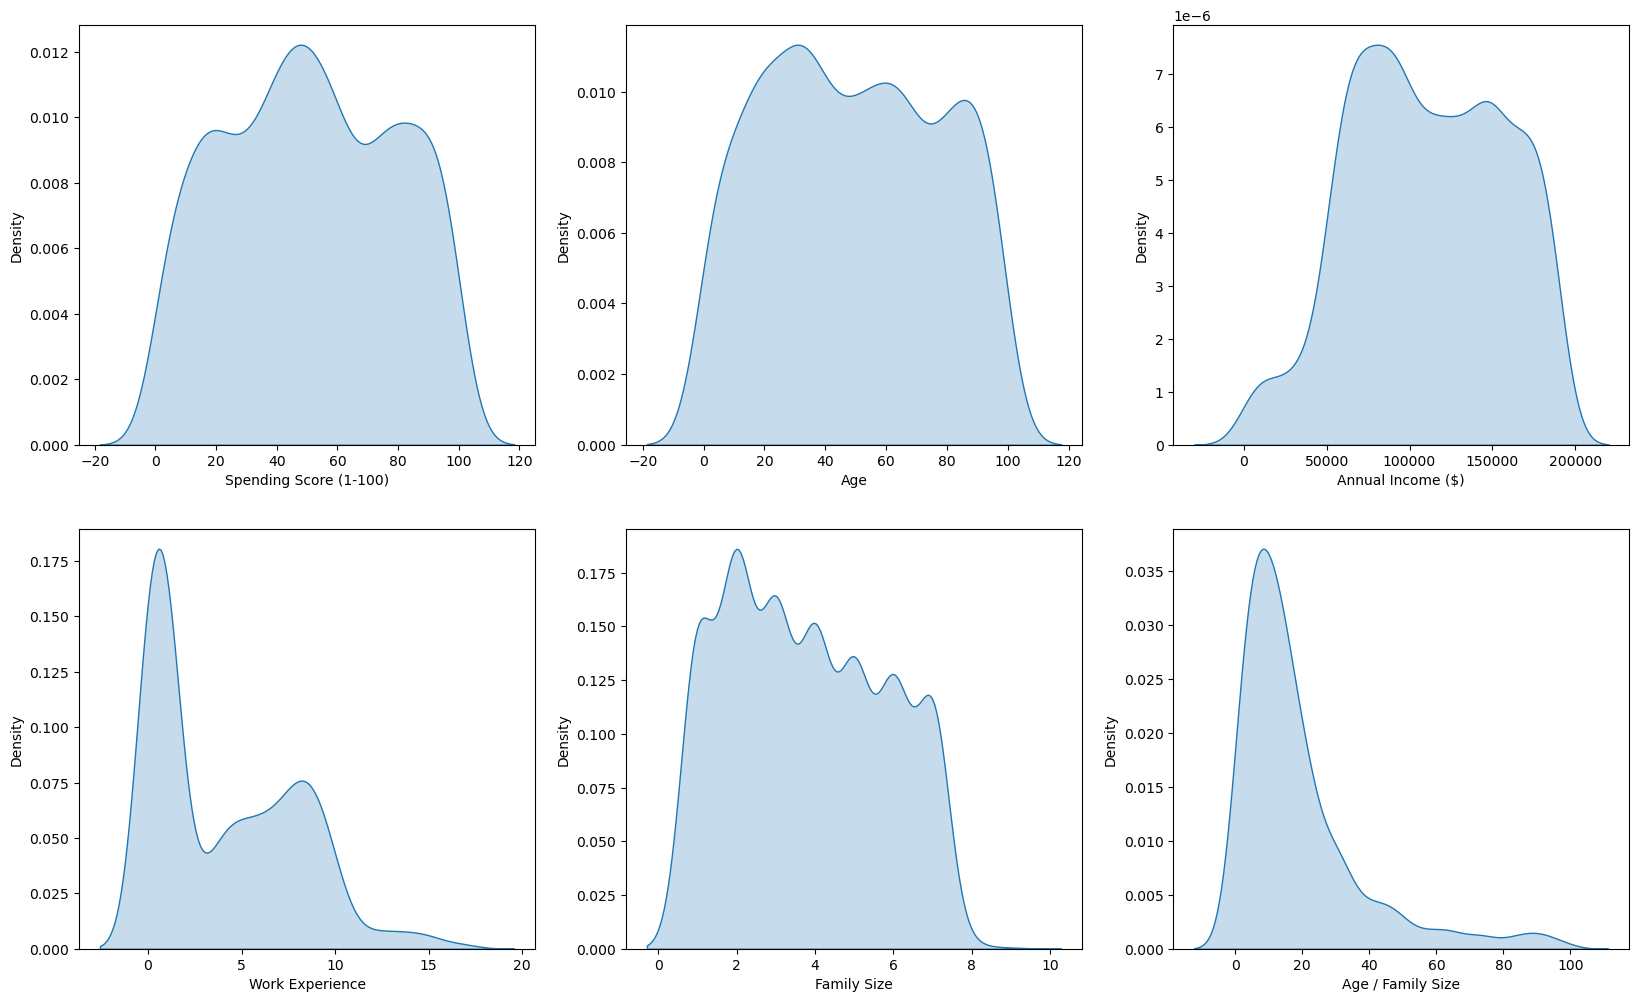

In [6]:
fig, axes = plt.subplots(2, 3, figsize = (20, 12))

sns.kdeplot(ax = axes[0,0], x = 'Spending Score (1-100)', data = customers, fill = True);
sns.kdeplot(ax = axes[0,1], x = 'Age', data = customers, fill = True);
sns.kdeplot(ax = axes[0,2], x = 'Annual Income ($)', data = customers, fill = True);
sns.kdeplot(ax = axes[1,0], x = 'Work Experience', data = customers, fill = True);
sns.kdeplot(ax = axes[1,1], x = 'Family Size', data = customers, fill = True);
sns.kdeplot(ax = axes[1,2], x = (customers['Age'] / customers['Family Size']), fill = True).set(xlabel = 'Age / Family Size');

The above plots show that many of our features have a slight skew. This skew does not seem strong enough to consider any sort of transformation. <br>
Although, Age / Family Size gives a strongly skewed distribution that could bennifit from a log transformation

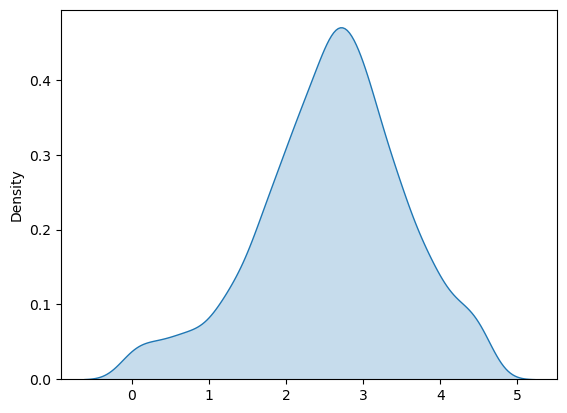

In [7]:
## Log transformation for Age / Family Size ##
sns.kdeplot(x = np.log1p(customers['Age'] / customers['Family Size']), fill = True);

This is an interesting idea for a feature we could try. 

##### Strong Heredity Principle

In [31]:
## Convert categorical features to dummies ##
customers = pd.concat([customers.drop(columns = ['Gender', 'Profession'], axis = 1), pd.get_dummies(customers[['Gender', 'Profession']])], axis = 1)

In [9]:
## Inputs and Target ##
X = customers.drop(columns = 'Spending Score (1-100)')
Y = customers['Spending Score (1-100)']

## Model ##
md = AdaBoostRegressor(estimator = DecisionTreeRegressor(max_depth = 3), n_estimators = 500, learning_rate = .1)

In [10]:
importance = list()
for i in (0, 10):
    print(i)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .2)
    md.fit(X_train, Y_train)
    importance.append(md.feature_importances_)
    clear_output()
    
pd.DataFrame({'Feature': X.columns.values, 'Importance': pd.DataFrame(pd.DataFrame(importance).apply(np.mean, axis = 0))[0].values}).sort_values(by = 'Importance', ascending = False)

,Feature,Importance
1,Annual Income ($),0.438192
0,Age,0.203153
2,Work Experience,0.131109
3,Family Size,0.077310
6,Profession_Artist,0.055962
8,Profession_Engineer,0.016075
9,Profession_Entertainment,0.012594
4,Gender_Female,0.010769
11,Profession_Healthcare,0.009994
7,Profession_Doctor,0.009803


The most important features are very clearly Annual Income and Age. Work Experience and Family Size come next. It would seem likely that Age and Work Experience would have some sort of interaction with each other. Also create a feature for Annual Income and Age

## Feature Engineering

In [32]:
## Interactions ##
customers['interaction_1'] = customers['Annual Income ($)'] * customers['Work Experience']
customers['interaction_2'] = customers['Family Size'] * customers['Annual Income ($)']

## Strong Heredity Principal ##
customers['feature_1'] = customers['Annual Income ($)'] * customers['Age']
customers['feature_2'] = customers['Work Experience'] * customers['Age']

## Engineered Feature ##
customers['feature_3'] = np.log1p(customers['Age'] / customers['Family Size'])

In [33]:
train, test = train_test_split(customers, test_size = .2)

# RFE

In [13]:
features = pd.DataFrame(columns = ['ada'])

for i in range(2):
    print(i)
    
    ## split data ##
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .2, stratify = Y)
    
    ## Models ##
    rfe = RFECV(estimator = md, step = 1, min_features_to_select = 2, cv = 5).fit(X_train, Y_train)

    ## Results ##
    features = features.append({
        'ada': X_train.columns[rfe.support_].tolist()},
        ignore_index = True
    )
    
    clear_output()

The above cell was ran through 100 iterations in the python script 'Exam 1 RFE'.py

In [25]:
## Featrues Data Frame ##
features = pd.read_csv('Features.csv')

## Extract Features ##
all_features  = list()
for feature_list in features[md_features].apply(ast.literal_eval):
    for feature in feature_list:
        all_features.append(feature)

## Count of Features ##
pd.DataFrame(all_features).value_counts()

Annual Income ($)           99
feature_1                   96
interaction_2               94
interaction_1               89
feature_3                   89
feature_2                   83
Age                         73
Work Experience             65
Family Size                 63
Gender_Female               49
Profession_Artist           48
Gender_Male                 45
Profession_Healthcare       40
Profession_Engineer         34
Profession_Doctor           32
Profession_Homemaker        26
Profession_Marketing        26
Profession_Executive        25
Profession_Entertainment    23
Profession_Lawyer           13
dtype: int64

##### Top 6 Features
<ol>
<li>Annual Income ($)
<li>feature_1
<li>interaction_2
<li>interaction_1
<li>feature_3
<li>feature_2
<ol>

# Models

In [34]:
md = AdaBoostRegressor(estimator = DecisionTreeRegressor(max_depth = 3), n_estimators = 500, learning_rate = .1)

In [37]:
## Model with top 5 features ##

## Inputs and Target ##
X_train_1 = train[['Annual Income ($)', 'feature_1', 'interaction_2', 'interaction_1', 'feature_3']]
X_test_1 = test[['Annual Income ($)', 'feature_1', 'interaction_2', 'interaction_1', 'feature_3']]
Y_train = train['Spending Score (1-100)']

## Model ##
md_1 = md.fit(X_train_1, Y_train)

## Prediction ##
pred_1 = md_1.predict(X_test_1)

## Metric ##
print('RMSE of md_1 (Top 5 Features):', mean_squared_error(test['Spending Score (1-100)'], pred_1, squared = False))

RMSE of md_1 (Top 5 Features): 28.228626724780494


In [38]:
## Model with top 6 features ##

## Inputs and Target ##
X_train_2 = train[['Annual Income ($)', 'feature_1', 'interaction_2', 'interaction_1', 'feature_3', 'feature_2']]
X_test_2 = test[['Annual Income ($)', 'feature_1', 'interaction_2', 'interaction_1', 'feature_3', 'feature_2']]
Y_train = train['Spending Score (1-100)']

## Model ##
md_2 = md.fit(X_train_2, Y_train)

## Prediction ##
pred_2 = md_2.predict(X_test_2)

## Metric ##
print('RMSE of md_2 (Top 6 Features):', mean_squared_error(test['Spending Score (1-100)'], pred_2, squared = False))

RMSE of md_2 (Top 6 Features): 28.321071854171755


Based on the results of both models, it is hard to tell which is best for predicting spending score. I ran both models multiple times and they went back and forth with having the best score. <br> Because of this, I would use md_1, using the top 5 features since it is the simpler model. 